# t-SNE on IMDB Movie Review Dataset

**Dataset Source:**  
[IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

The dataset contains 50,000 movie reviews from IMDB labeled as "positive" or "negative."

In [5]:
# =========================================
# 1. Import Libraries
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

# For ignoring harmless warnings
import warnings
warnings.filterwarnings('ignore')

# Download NLTK stopwords (if needed)
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# =========================================
# 2. Load the Dataset
# =========================================
# Ensure 'IMDB Dataset.csv' (or the correct file name) is in the same directory as this notebook.
# The CSV should have two columns: 'review' and 'sentiment'.

data = pd.read_csv('/IMDB Dataset.csv')  # Replace with your actual file path if needed
print("Data shape:", data.shape)

# Display the first 5 rows to get a sense of the data
data.head()

Data shape: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
# =========================================
# 3. Basic Exploration
# =========================================

# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

# Check the distribution of sentiments
print("\nSentiment distribution:")
print(data['sentiment'].value_counts())

Missing values per column:
review       0
sentiment    0
dtype: int64

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [8]:
# =========================================
# 4. Subset the Data (Optional)
# =========================================
# Because t-SNE can be computationally expensive, we may limit the data.
# Here, we take a balanced sample of 2000 reviews (1000 positive, 1000 negative) for demonstration.

pos_subset = data[data['sentiment'] == 'positive'].sample(n=1000, random_state=42)
neg_subset = data[data['sentiment'] == 'negative'].sample(n=1000, random_state=42)
data_sample = pd.concat([pos_subset, neg_subset]).reset_index(drop=True)

print("New data shape after sampling:", data_sample.shape)
print(data_sample['sentiment'].value_counts())
data_sample.head()

New data shape after sampling: (2000, 2)
sentiment
positive    1000
negative    1000
Name: count, dtype: int64


,review,sentiment
0,I don't know how or why this film has a meager...,positive
1,For a long time it seemed like all the good Ca...,positive
2,Terry Gilliam's and David Peoples' teamed up t...,positive
3,What is there to say about an anti-establishme...,positive
4,This movie was made only 48 years after the en...,positive


In [9]:
# =========================================
# 5. Clean & Preprocess Text
# =========================================
# We'll remove punctuation, convert text to lowercase, and remove stopwords.

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub('[^a-z]+', ' ', text)
    # Tokenize and remove stopwords
    tokens = [word for word in text.split() if word not in stop_words]
    # Join back to string
    return ' '.join(tokens)

data_sample['cleaned_review'] = data_sample['review'].apply(clean_text)
data_sample.head()

,review,sentiment,cleaned_review
0,I don't know how or why this film has a meager...,positive,know film meager rating imdb film accompanied ...
1,For a long time it seemed like all the good Ca...,positive,long time seemed like good canadian actors hea...
2,Terry Gilliam's and David Peoples' teamed up t...,positive,terry gilliam david peoples teamed create one ...
3,What is there to say about an anti-establishme...,positive,say anti establishment film produced time colo...
4,This movie was made only 48 years after the en...,positive,movie made years end civil war likely anticipa...


In [10]:
# =========================================
# 6. Convert Text to Numeric Features (TF-IDF)
# =========================================
# We'll transform the cleaned text into TF-IDF vectors.

vectorizer = TfidfVectorizer(max_features=2000)  # limit features for speed
X_tfidf = vectorizer.fit_transform(data_sample['cleaned_review'])

print("TF-IDF matrix shape:", X_tfidf.shape)

TF-IDF matrix shape: (2000, 2000)


In [11]:
# =========================================
# 7. Apply t-SNE
# =========================================
# We reduce the high-dimensional TF-IDF vectors to 2D for visualization.
# t-SNE can take a while depending on dataset size and parameters.

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_tfidf.toarray())

print("Shape of t-SNE output:", X_tsne.shape)
print("Divergence:", tsne.kl_divergence_)

Shape of t-SNE output: (2000, 2)
Divergence: 2.6354620456695557


###**Checking perplexity vs. divergence**
Perplexity is an important hyperparameter for the t-SNE algorithm. It controls the effective number of neighbors that each point considers during the dimensionality reduction process.

We will run a loop to get the KL Divergence metric on various perplexities from 5 to 55 with a 5-point gap.

In [13]:
#==========================================
# 7a. Checking perplexity vs divergence
#==========================================
import plotly.express as px

perplexity = np.arange(5, 55, 5)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(X_tfidf.toarray())
    divergence.append(model.kl_divergence_)
fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

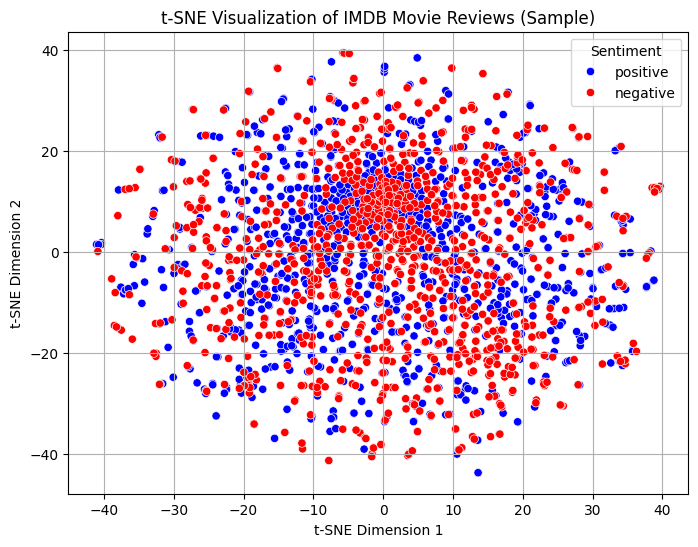

In [14]:
# =========================================
# 8. Visualize the 2D t-SNE Embedding
# =========================================
# We'll create a scatter plot of the 2D representation, coloring points by sentiment.

sentiment_colors = {'positive': 'blue', 'negative': 'red'}
data_sample['tsne_x'] = X_tsne[:, 0]
data_sample['tsne_y'] = X_tsne[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='tsne_x',
    y='tsne_y',
    hue='sentiment',
    data=data_sample,
    palette=sentiment_colors
)
plt.title("t-SNE Visualization of IMDB Movie Reviews (Sample)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

## 9. Discussion & Conclusion

- **t-SNE** is a powerful tool for visualizing high-dimensional data.
- Here, it helps us see if there's a natural separation between positive and negative sentiment.
- The separation may not be perfect, but often you'll observe clusters that roughly correspond to different sentiments.
- **Tips for Better Results:**  
  - Try different values of `perplexity`, `learning_rate`, and `n_iter`.
  - Use more data (be mindful of computational time).
  - Consider alternative embedding methods like UMAP or PCA if t-SNE is too slow.

## Further Reading
- [Official t-SNE Paper by van der Maaten & Hinton](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)  
- [Scikit-learn TSNE Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)  
- [Kaggle IMDB Reviews Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
